In [1]:
import numpy as np
import pandas as pd

from transformer_thermal_model.cooler import CoolerType
from transformer_thermal_model.hot_spot_calibration import calibrate_hotspot_factor
from transformer_thermal_model.model import Model
from transformer_thermal_model.schemas import (
    InputProfile,
    ThreeWindingInputProfile,
    UserThreeWindingTransformerSpecifications,
    UserTransformerSpecifications,
    WindingSpecifications,
)
from transformer_thermal_model.transformer import PowerTransformer, ThreeWindingTransformer
import matplotlib.pyplot as plt


In [2]:
# run the model for a normal transformer
one_week = 4 * 24 * 7
datetime_index = [pd.to_datetime("2025-07-01 00:00:00") + pd.Timedelta(minutes=15 * i) for i in np.arange(0, one_week)]

# Initialise a power transformer with cooling type ONAF and, besides the mandatory user specifications, default values.
tr_specs = UserTransformerSpecifications(
    load_loss=1000,  # Transformer load loss [W]
    nom_load_sec_side=1500,  # Transformer nominal current secondary side [A]
    no_load_loss=200,  # Transformer no-load loss [W]
    amb_temp_surcharge=0,  # Ambient temperature surcharge [K]
)

transformer = PowerTransformer(user_specs=tr_specs, cooling_type=CoolerType.ONAF)
nominal_load = 100
load_points = pd.Series([nominal_load] * one_week, index=datetime_index)
ambient_temp = 20
temperature_points = pd.Series([ambient_temp] * one_week, index=datetime_index)

# Create an input object with the profiles
continuous_load = pd.Series([transformer.specs.nom_load_sec_side] * one_week, index=datetime_index)
ambient_series = pd.Series(data=20, index=datetime_index)
model_input = InputProfile.create(
    datetime_index=datetime_index, load_profile=continuous_load, ambient_temperature_profile=ambient_series
)

uncalibrated_transformer = transformer
calibrated_trafo = calibrate_hotspot_factor(
    uncalibrated_transformer=uncalibrated_transformer,
    ambient_temp=20.0,
    hot_spot_limit=98,  # in most cases a hot-spot temperature limit of 98 can be used
    hot_spot_factor_min=1.1,
    hot_spot_factor_max=1.3,
)
model = Model(temperature_profile=model_input, transformer=calibrated_trafo)
results = model.run()


/tmp/ipykernel_5653/3699525761.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


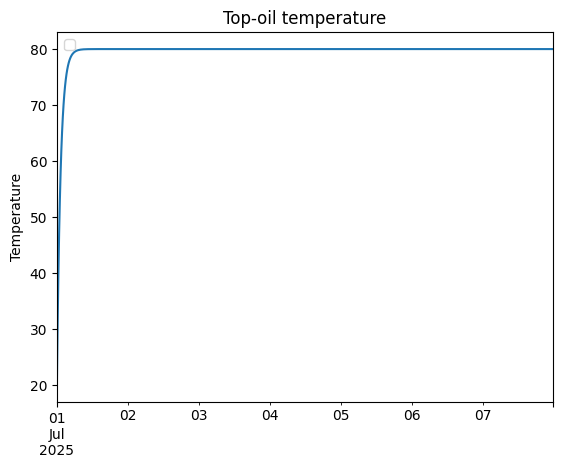

/tmp/ipykernel_5653/3699525761.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


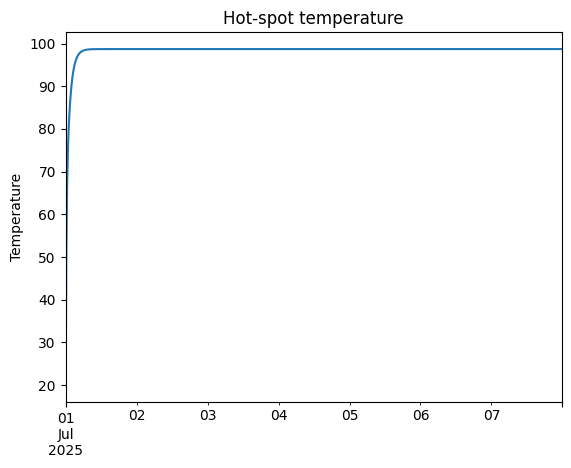

In [3]:
model = Model(temperature_profile=model_input, transformer=calibrated_trafo)
results = model.run()

top_oil_temp_profile = results.top_oil_temp_profile
hot_spot_temp_profile = results.hot_spot_temp_profile

# plot hotspot temp
fig, ax = plt.subplots()
top_oil_temp_profile.plot(ax=ax)
ax.set_title('Top-oil temperature')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

fig, ax2 = plt.subplots()
hot_spot_temp_profile.plot(ax=ax2)
ax2.set_title('Hot-spot temperature')
ax2.set_ylabel('Temperature')
ax.legend()
plt.show()

In [2]:
# run the model for a threewind transformer

# Define the time range for your simulation
datetime_index = [pd.to_datetime("2025-07-01 00:00:00") + pd.Timedelta(minutes=15 * i) for i in np.arange(0, 288)]

load_series_high = pd.Series(
    data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index
)
load_series_middle = pd.Series(
    data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index
)
load_series_low = pd.Series(
    data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index
)

ambient_series = pd.Series(data=0, index=datetime_index)

# Create the input profile for the three-winding transformer
profile_input = ThreeWindingInputProfile.create(
    datetime_index=datetime_index,
    ambient_temperature_profile=ambient_series,
    load_profile_high_voltage_side=load_series_high,
    load_profile_middle_voltage_side=load_series_middle,
    load_profile_low_voltage_side=load_series_low,
)

# specs that give a calibrated hotspotfactor of 1.16 with the current function

user_specs = UserThreeWindingTransformerSpecifications(
    no_load_loss=34000,
    amb_temp_surcharge=0,
    lv_winding=WindingSpecifications(
        nom_load=1300,
        winding_oil_gradient=15.0,
        time_const_winding=7,
        nom_power=25
    ),
    mv_winding=WindingSpecifications(
        nom_load=1045,
        winding_oil_gradient=15.5,  # was 11.4 → iets hoger
        time_const_winding=7,
        nom_power=95
    ),
    hv_winding=WindingSpecifications(
        nom_load=366,
        winding_oil_gradient=15.0,  # was 11.8 → iets hoger
        time_const_winding=7,
        nom_power=95
    ),
    load_loss_hv_lv=95000,   # was 102100 → iets lager
    load_loss_hv_mv=245000,  # was 259000 → iets lager
    load_loss_mv_lv=95000    # was 100300 → iets lager
)

# Create the transformer object
transformer = ThreeWindingTransformer(user_specs=user_specs, cooling_type=CoolerType.ONAN)
model = Model(temperature_profile=profile_input, transformer=transformer)
results = model.run()

In [3]:
calibrated_trafo = calibrate_hotspot_factor(
    uncalibrated_transformer=transformer,
    ambient_temp=20.0,
    hot_spot_limit=98,  # in most cases a hot-spot temperature limit of 98 can be used
    hot_spot_factor_min=1.1,
    hot_spot_factor_max=1.3,
)
calibrated_trafo.specs.mv_winding.hot_spot_fac

np.float64(1.16)

/tmp/ipykernel_7124/4035650309.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


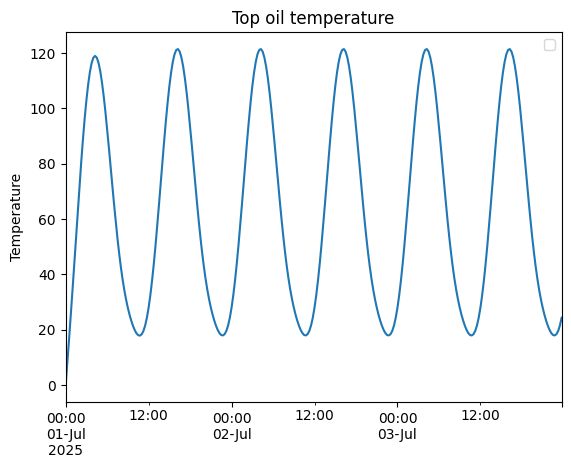

/tmp/ipykernel_7124/4035650309.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


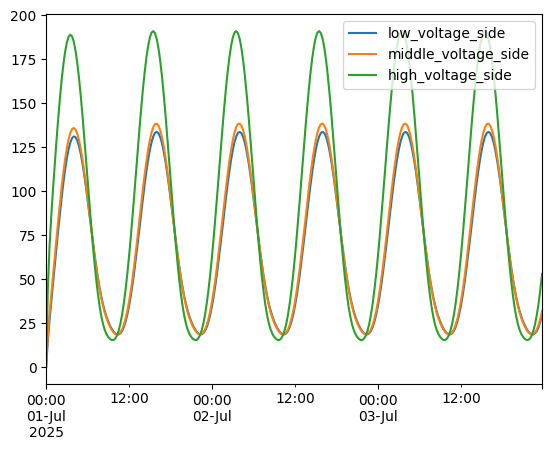

In [4]:
# step 2: using the same specs as above, calculate the hotspot and topoil temperature
#Je rekent met dezelfde specs uit stap 1 en met de nieuwe hotspotfactor (die je per winding hetzelfde invult)
#  de hotspot temperatuur en de topolie temperatuur door. > Ik weet even niet zeker welke stroom gebruikt wordt voor de kalibratie: 
# maar deze moet je dan ook als input hetzelfde doen. Hetzelfde geldt voor de omgevingstemperatuur: volgens mij staat deze op 20 graden?
model = Model(temperature_profile=profile_input, transformer=calibrated_trafo)
results = model.run()

top_oil_temp_profile = results.top_oil_temp_profile
hot_spot_temp_profile = results.hot_spot_temp_profile

# plot temp profiles
fig, ax = plt.subplots()
top_oil_temp_profile.plot(ax=ax)
ax.set_title('Top oil temperature')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

fig, ax2 = plt.subplots()
hot_spot_temp_profile.plot(ax=ax2)
ax.set_title('Hot-spot temperature')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()


/tmp/ipykernel_3519/683233564.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


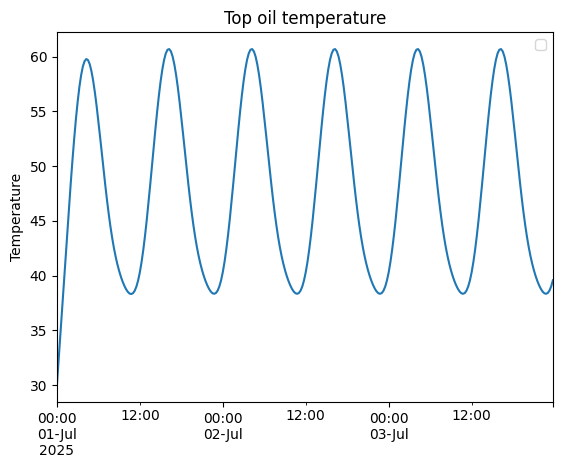

/tmp/ipykernel_3519/683233564.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


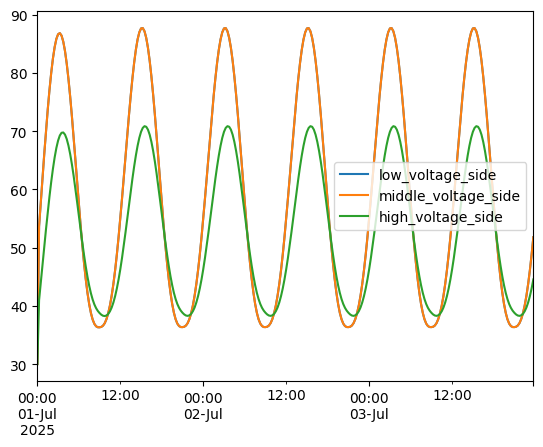

In [59]:
# Define the transformer specifications for each winding
user_specs = UserThreeWindingTransformerSpecifications(
    no_load_loss=20,
    amb_temp_surcharge=10,
    lv_winding=WindingSpecifications(
        nom_load=1000, winding_oil_gradient=20, hot_spot_fac=1.2, time_const_winding=1, nom_power=1000
    ),
    mv_winding=WindingSpecifications(
        nom_load=1000, winding_oil_gradient=20, hot_spot_fac=1.2, time_const_winding=1, nom_power=1000
    ),
    hv_winding=WindingSpecifications(
        nom_load=2000, winding_oil_gradient=20, hot_spot_fac=1.2, time_const_winding=1, nom_power=2000
    ),
    load_loss_hv_lv=100,
    load_loss_hv_mv=100,
    load_loss_mv_lv=100,
)

# Create the transformer object
transformer = ThreeWindingTransformer(user_specs=user_specs, cooling_type=CoolerType.ONAN)

model = Model(temperature_profile=profile_input, transformer=transformer)
results = model.run()

top_oil_temp_profile = results.top_oil_temp_profile
hot_spot_temp_profile = results.hot_spot_temp_profile

# plot temp profiles
fig, ax = plt.subplots()
top_oil_temp_profile.plot(ax=ax)
ax.set_title('Top oil temperature')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

fig, ax2 = plt.subplots()
hot_spot_temp_profile.plot(ax=ax2)
ax.set_title('Hot-spot temperature')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()